# Automated Bug Priority Predictor

## Overview
This project aims to develop a machine learning model that predicts the **priority level of software bug reports** based on their text descriptions and metadata.
By automating the triage process, software teams can save time and focus on resolving critical issues faster.

**Datasets:** ISEC Data Challenge https://www.kaggle.com/competitions/isec-sdc-2025/overview

---

# Exploration Data Analysis

## Objective
Explore and clean the data to prepare it for model training in the next phase.

## Notebook Goals
1. Load and inspect the dataset.
2. Understand column types and distribution.
3. Handle missing values and duplicates.
4. Clean and normalize text fields (tokenization, stopwords, lemmatization).
5. Prepare a clean dataset for feature extraction and modeling

## Imports and Setup

In [56]:
#Standard libraries
import re
from collections import Counter

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Utilities
import joblib

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rusty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rusty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load and Inspect Data

In [57]:
train_df = pd.read_csv("../../data/raw/train.csv")
test_df = pd.read_csv("../../data/raw/test.csv")

In [58]:
train_df

,Issue_id,Component,Title,Description,Status,Resolution,Priority
0,1700,Layout,font size 9px rounded down to 8px {font} {ll},There is a piece of code in the Windows GFX th...,VERIFIED,FIXED,0
1,7991,Plug-ins,Land OOP plugins in mozilla-central (preffed off),We need to land OOP plugins in mozilla-central...,RESOLVED,FIXED,0
2,1150,XPCOM,XP-COM Proxy code crashes when trying to AutoP...,(This bug imported from BugSplat; Netscapes in...,VERIFIED,FIXED,0
3,6143,XUL,crash setting display:none on grid rows [@ nsG...,User-Agent: Mozilla/5.0 (Windows; U; Win...,VERIFIED,FIXED,0
4,5952,Networking: Cache,limit the memory cache to a reasonable value,I have 1GB of RAM; so Im using 31MB of memory ...,VERIFIED,FIXED,0
...,...,...,...,...,...,...,...
52989,53192,Team,Replicate functionality (1GGP770),In regular use; it is often necessary to be ab...,RESOLVED,WONTFIX,4
52990,53717,CSS Parsing and Computation,[charset]Improve @charset parsing in CSSLoader...,Separated from bug 72658.; ; http://lxr.mozill...,RESOLVED,FIXED,4
52991,53242,Migration,iCab Profile Migrator,.,RESOLVED,WONTFIX,4
52992,53682,DOM: Core & HTML,The tableSectionElement.ch doesnt have a defau...,Overview Description: ; The tableSectionElemen...,VERIFIED,FIXED,4


In [59]:
train_df.shape

(52994, 7)

In [60]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52994 entries, 0 to 52993
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Issue_id     52994 non-null  int64 
 1   Component    52994 non-null  object
 2   Title        52994 non-null  object
 3   Description  52602 non-null  object
 4   Status       52994 non-null  object
 5   Resolution   52994 non-null  object
 6   Priority     52994 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.8+ MB


In [61]:
train_df.isnull().sum()

Issue_id         0
Component        0
Title            0
Description    392
Status           0
Resolution       0
Priority         0
dtype: int64

In [62]:
train_df["Priority"].value_counts()

Priority
2    31154
1     9412
0     8943
3     2287
4     1198
Name: count, dtype: int64

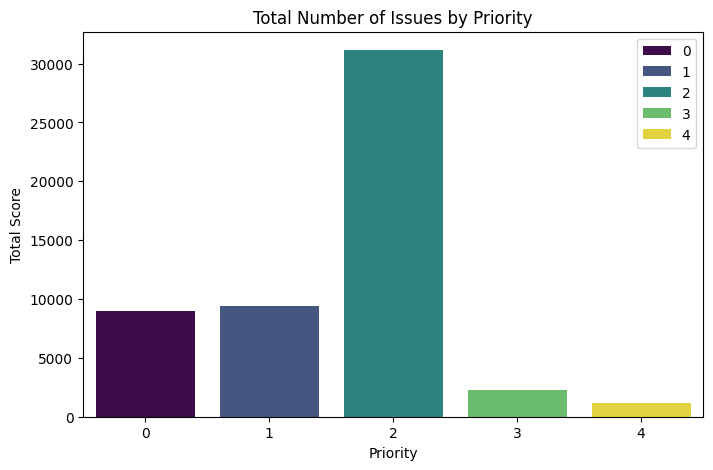

In [63]:
priority_dict = train_df["Priority"].value_counts().to_dict()
plt.figure(figsize=(8,5))
sns.barplot(
  x=list(priority_dict.keys()), 
  y=list(priority_dict.values()), 
  hue=list(priority_dict.keys()),
  palette="viridis"
)
plt.title("Total Number of Issues by Priority")
plt.xlabel("Priority")
plt.ylabel("Total Score")
plt.show()

In [64]:
# List of descriptions per priority
train_df["Description"] = train_df["Description"].fillna("").astype(str)
grouped = train_df.groupby("Priority")["Description"].apply(lambda x: np.mean([len(text.split()) for text in x]))
grouped

Priority
0    116.869507
1    100.335104
2    103.180940
3     94.988631
4    142.715359
Name: Description, dtype: float64

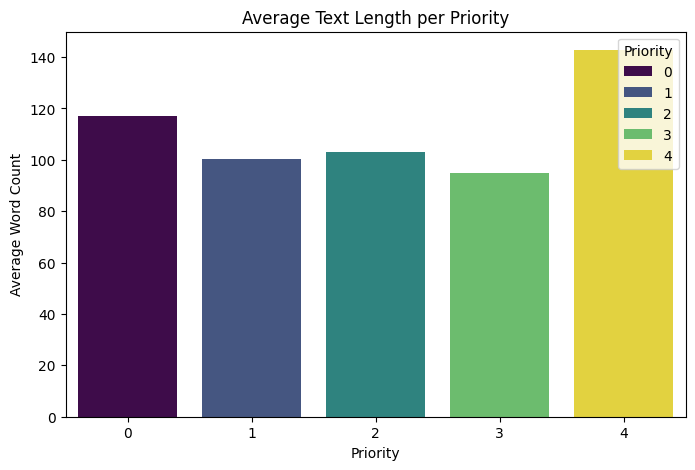

In [65]:
plt.figure(figsize=(8,5))
sns.barplot(
  x=grouped.index, 
  y=grouped.values,
  hue=grouped.index,
  palette="viridis"
)
plt.title("Average Text Length per Priority")
plt.xlabel("Priority")
plt.ylabel("Average Word Count")
plt.show()

In [66]:
# Create a DataFrame with number of words per title, description, and combined text
text_lengths_df = pd.DataFrame()
text_lengths_df["Title_Length"] = train_df["Title"].apply(lambda x: len(x.split()) if pd.notnull(x) else 0 )
text_lengths_df["Description_Length"] = train_df["Description"].apply(lambda x: len(x.split()) if pd.notnull(x) else 0 )

text_lengths_df.describe()

,Title_Length,Description_Length
count,52994.000000,52994.000000
mean,7.886855,105.525701
std,3.375861,154.644415
min,1.000000,0.000000
25%,6.000000,39.000000
50%,8.000000,70.000000
75%,10.000000,121.000000
max,46.000000,4122.000000


In [67]:
def plot_histogram(text_df, column_name):
  """
  Plot a histogram showing the distribution of word counts for a given column.

  Args:
      text_df (pd.DataFrame): DataFrame containing the text data.
      column_name (str): The name of the column to plot (should contain numeric values).
  """
  plt.figure(figsize=(8,5))
  plt.hist(text_df[column_name], bins=50, color='skyblue', edgecolor='black')
  plt.title(f"Distribution of {column_name}")
  plt.xlabel("Number of Words")
  plt.ylabel("Frequency")
  plt.show()

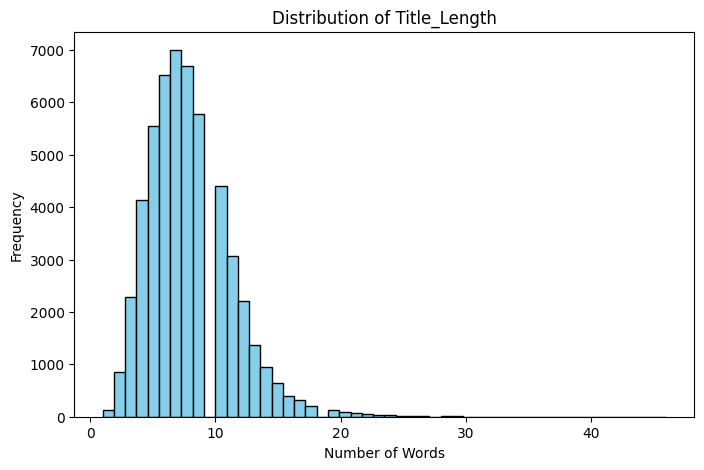

In [68]:
plot_histogram(text_lengths_df, "Title_Length")

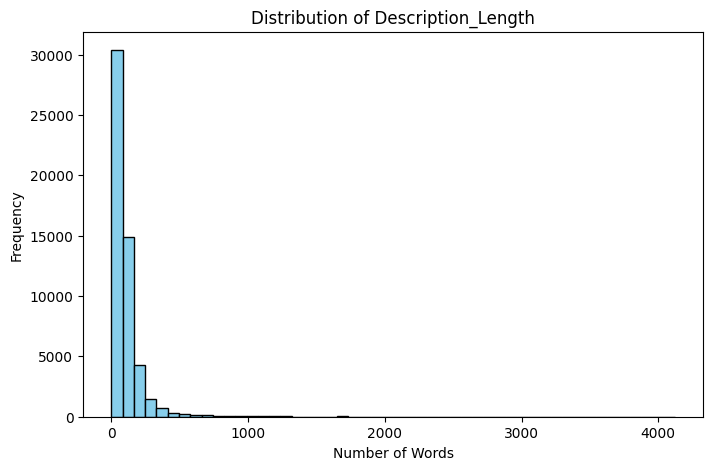

In [69]:
plot_histogram(text_lengths_df, "Description_Length")

In [70]:
text_lengths = text_lengths_df[["Description_Length", "Title_Length"]]
max_lengths = np.percentile(text_lengths, 95)
print("95th percentile of text length: ", max_lengths)

95th percentile of text length:  201.0


In [71]:
median_length = np.median(text_lengths)
max_length = np.max(text_lengths)
min_length = np.min(text_lengths)

print("Median length: ", median_length)
print("Max length: ", max_length)
print("Min length: ", min_length)

Median length:  14.0
Max length:  4122
Min length:  0


In [72]:
# Number of rows in text with less than equal to 296
num_text_to_target = sum(text_lengths_df["Description_Length"] <= 296)
percentage_of_target = (num_text_to_target / len(text_lengths_df)) * 100

print("Number of rows less than equal to target token limit: ", num_text_to_target)
print("Percentage of rows to the target token limit: ", percentage_of_target)

Number of rows less than equal to target token limit:  50507
Percentage of rows to the target token limit:  95.30701588859117


#### Set tokenizer max_length = 296, this will truncate outliers

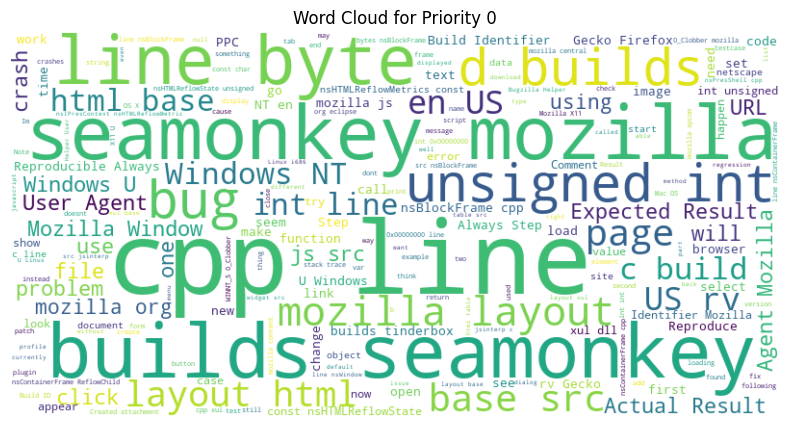

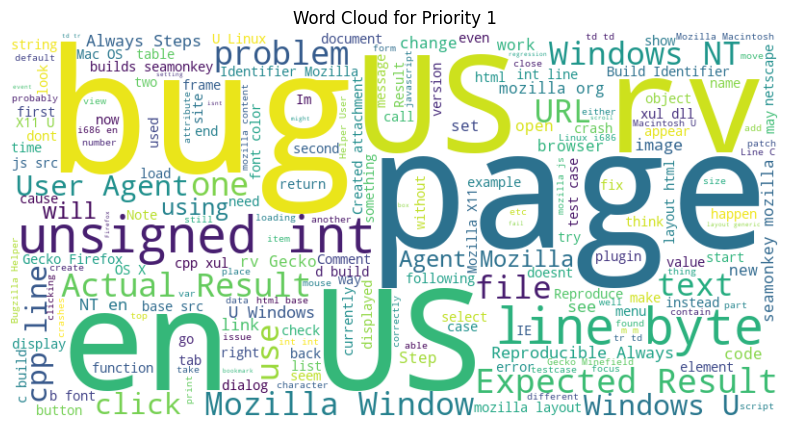

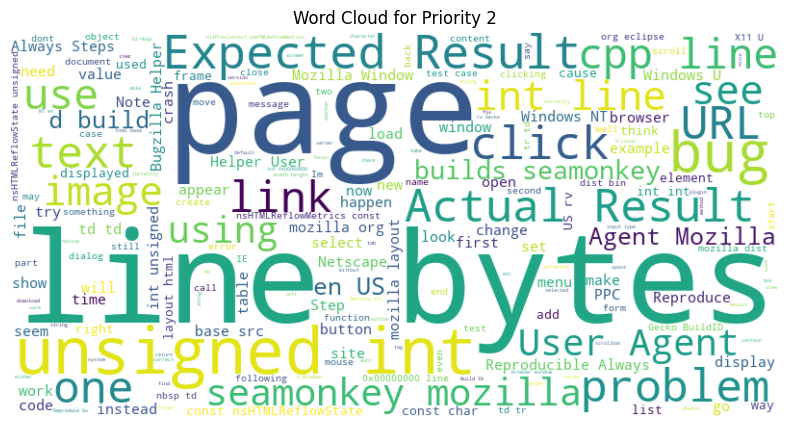

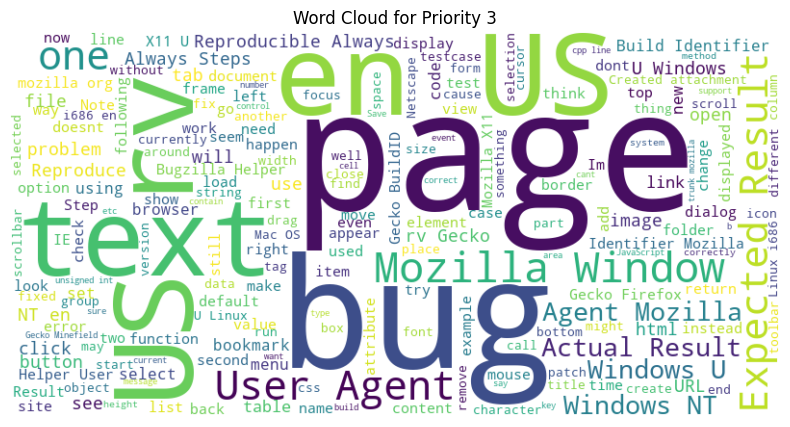

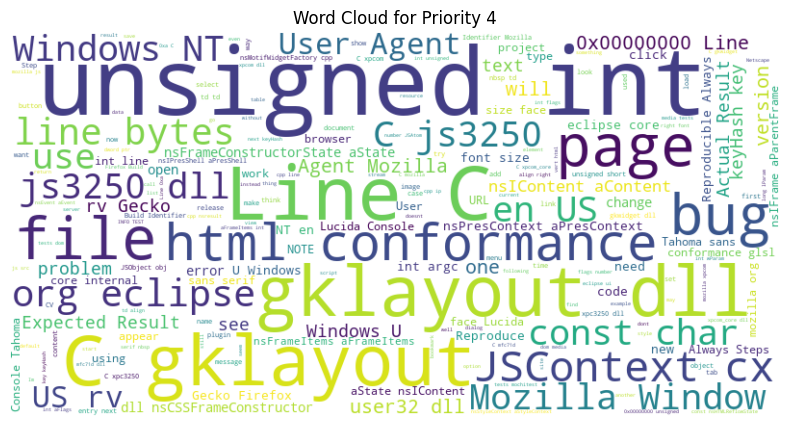

In [73]:
priority_list = train_df["Priority"].unique()

for priority_value in priority_list:
  subset = train_df[train_df["Priority"] == priority_value]
  text = " ".join(subset["Description"].astype(str))
  
  wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

  plt.figure(figsize=(10,5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Word Cloud for Priority {priority_value}")
  plt.show()

In [74]:
num_unique_components = len(train_df["Component"].unique())
print(f"Number of unique Components: {num_unique_components}")

Number of unique Components: 183


In [75]:
component_counts = train_df["Component"].value_counts()
component_counts.head(20)

Component
Layout                         6129
XUL                            4176
Editor                         3043
JavaScript Engine              2513
Networking                     2417
Layout: Tables                 2027
Layout: Form Controls          1810
CSS Parsing and Computation    1696
HTML: Parser                   1656
Plug-ins                       1552
Security: UI                   1539
DOM: Core & HTML               1517
Internationalization           1447
XPCOM                          1347
Event Handling                 1044
DOM                            1000
ImageLib                        808
HTML: Form Submission           791
Tracking                        750
Installer: XPInstall Engine     714
Name: count, dtype: int64

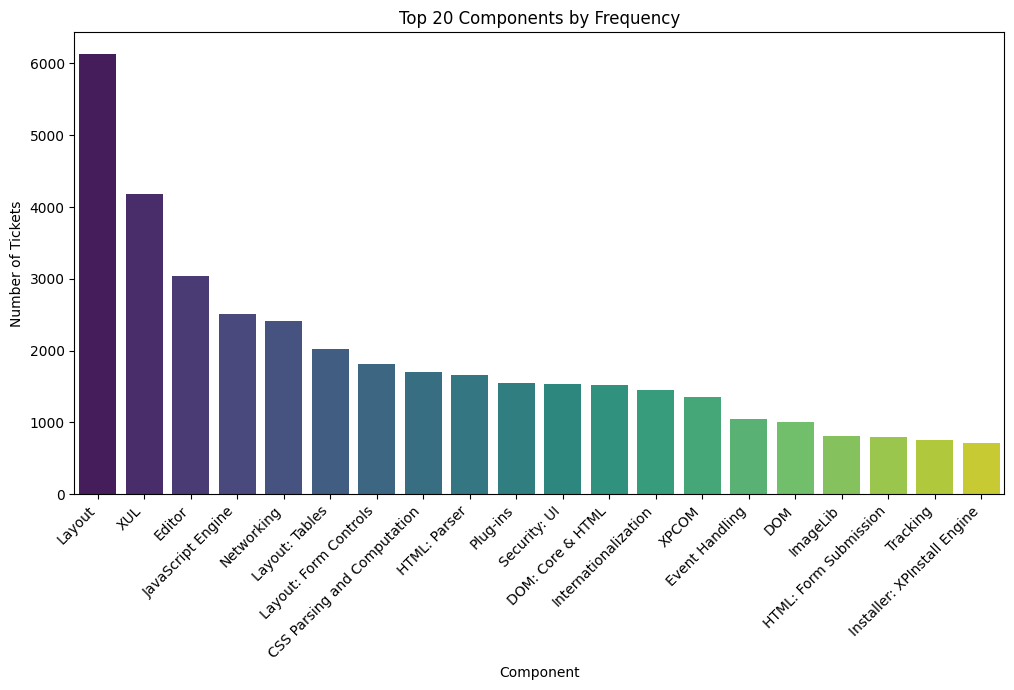

In [76]:
top_components = component_counts.head(20)
plt.figure(figsize=(12,6))
sns.barplot(
  x=top_components.index, 
  y=top_components.values,
  hue=top_components.index,
  palette="viridis",
  dodge=False
)
plt.title("Top 20 Components by Frequency")
plt.xlabel("Component")
plt.ylabel("Number of Tickets")
plt.xticks(rotation=45, ha="right")
plt.show()

In [77]:
# Number of unique component per priority
component_ct = pd.crosstab(train_df["Component"], train_df["Priority"])
component_ct

Priority,0,1,2,3,4
Component,,,,,
Account Manager,14,5,6,1,1
Address Book,3,1,5,1,1
Bookmarks & History,9,219,169,122,36
Build Config,57,51,37,6,15
CSS Parsing and Computation,223,399,928,112,34
...,...,...,...,...,...
XUL,436,483,3024,166,67
jemalloc,3,0,0,0,0
js-ctypes,15,2,2,0,0


In [78]:
# Percentage of unique component per priorities
component_ct_percentage = component_ct.div(component_ct.sum(axis=1), axis=0) * 100
component_ct_percentage

Priority,0,1,2,3,4
Component,,,,,
Account Manager,51.851852,18.518519,22.222222,3.703704,3.703704
Address Book,27.272727,9.090909,45.454545,9.090909,9.090909
Bookmarks & History,1.621622,39.459459,30.450450,21.981982,6.486486
Build Config,34.337349,30.722892,22.289157,3.614458,9.036145
CSS Parsing and Computation,13.148585,23.525943,54.716981,6.603774,2.004717
...,...,...,...,...,...
XUL,10.440613,11.566092,72.413793,3.975096,1.604406
jemalloc,100.000000,0.000000,0.000000,0.000000,0.000000
js-ctypes,78.947368,10.526316,10.526316,0.000000,0.000000


<Figure size 1600x800 with 0 Axes>

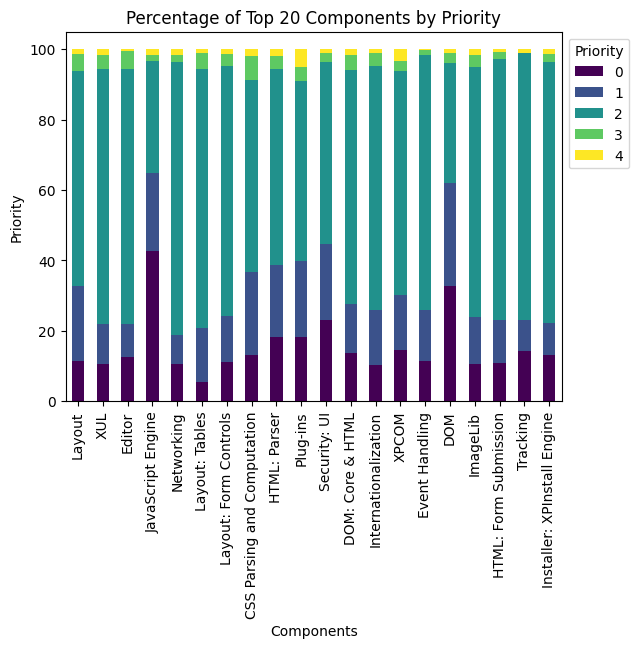

In [79]:
component_ct_top = component_ct_percentage.loc[top_components.index]

plt.figure(figsize=(16,8))
component_ct_top.plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Percentage of Top 20 Components by Priority")
plt.ylabel("Priority")
plt.xlabel("Components")
plt.legend(title="Priority", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [80]:
num_unique_status = len(train_df["Status"].unique())
print(f"Number of unique Status': {num_unique_status}")

Number of unique Status': 3


In [81]:
# Number of Issues per Status
status_counts = train_df["Status"].value_counts()
status_counts

Status
VERIFIED    34258
RESOLVED    18396
CLOSED        340
Name: count, dtype: int64

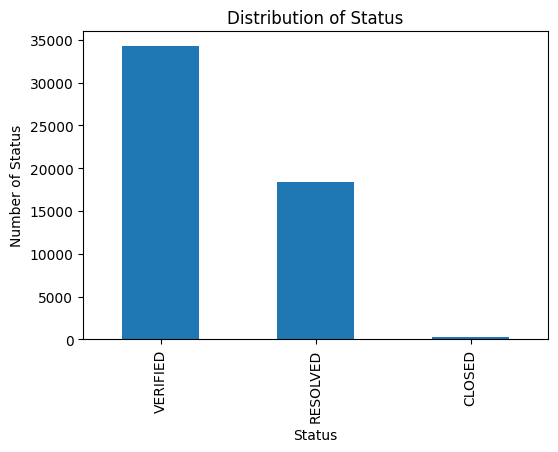

In [82]:
plt.figure(figsize=(6,4))
status_counts.plot(kind="bar")
plt.title("Distribution of Status")
plt.ylabel("Number of Status")
plt.xlabel("Status")
plt.show()

<Figure size 800x600 with 0 Axes>

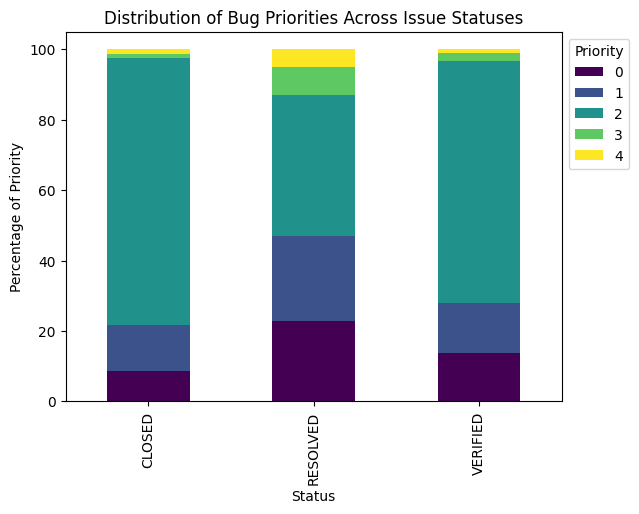

In [83]:
status_ct = pd.crosstab(train_df["Status"], train_df["Priority"])
status_ct_percentage = status_ct.div(status_ct.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8,6))
status_ct_percentage.plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Distribution of Bug Priorities Across Issue Statuses")
plt.ylabel("Percentage of Priority")
plt.xlabel("Status")
plt.legend(title="Priority", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [84]:
num_unique_resolution = len(train_df["Resolution"].unique())
print(f"Number of unique Resolutions: {num_unique_resolution}")

Number of unique Resolutions: 9


In [85]:
# Number of Issues per Resolution
resolution_counts = train_df["Resolution"].value_counts()
resolution_counts

Resolution
FIXED         28647
DUPLICATE     10367
WORKSFORME     7742
INVALID        3687
WONTFIX        2208
INCOMPLETE      257
NDUPLICATE       73
EXPIRED           8
MOVED             5
Name: count, dtype: int64

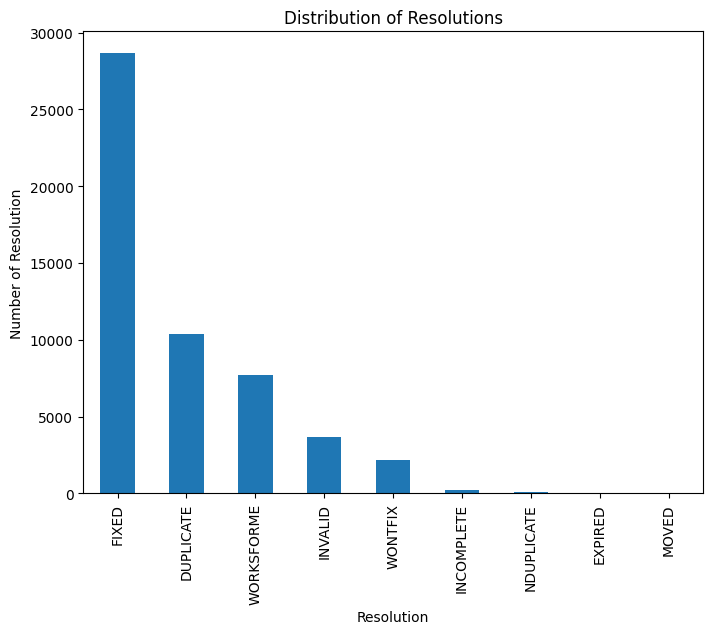

In [86]:
plt.figure(figsize=(8,6))
resolution_counts.plot(kind="bar")
plt.title("Distribution of Resolutions")
plt.ylabel("Number of Resolution")
plt.xlabel("Resolution")
plt.show()

<Figure size 800x600 with 0 Axes>

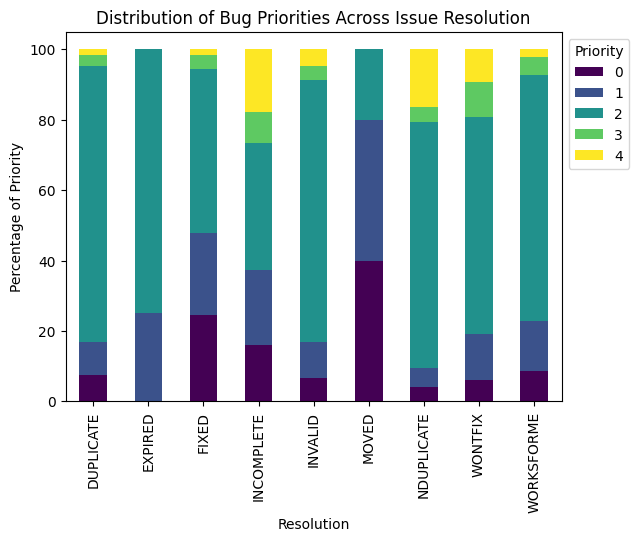

In [87]:
resolution_ct = pd.crosstab(train_df["Resolution"], train_df["Priority"])
resolution_ct_percentage = resolution_ct.div(resolution_ct.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8,6))
resolution_ct_percentage.plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Distribution of Bug Priorities Across Issue Resolution")
plt.ylabel("Percentage of Priority")
plt.xlabel("Resolution")
plt.legend(title="Priority", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [88]:
train_df.isnull().sum()

Issue_id       0
Component      0
Title          0
Description    0
Status         0
Resolution     0
Priority       0
dtype: int64

In [89]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52994 entries, 0 to 52993
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Issue_id     52994 non-null  int64 
 1   Component    52994 non-null  object
 2   Title        52994 non-null  object
 3   Description  52994 non-null  object
 4   Status       52994 non-null  object
 5   Resolution   52994 non-null  object
 6   Priority     52994 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.8+ MB


In [90]:
train_duplicates = train_df[train_df.duplicated(subset=["Title", "Description"], keep=False)]
print("Number of duplicate rows in Title and Description: ", train_duplicates.shape[0])

Number of duplicate rows in Title and Description:  419


In [91]:
train_duplicates.head()

,Issue_id,Component,Title,Description,Status,Resolution,Priority
2138,2689,Layout: Form Controls,text entry into forms is CPU intensive.,From Bugzilla Helper:; User-Agent: Mozilla/5.0...,VERIFIED,DUPLICATE,0
2608,1490,Layout,[Dogfood] Delete is removing all my text from ...,Im assuming this is a HTML element or form con...,VERIFIED,DUPLICATE,0
3099,1264,DOM,[CRASH] A crash occurs with a A element that c...,Version: Apprunner; Build: 1999082412 (Aug 24 ...,VERIFIED,FIXED,0
4107,1315,Editor,Crash Clicking Cancel button in Link Propertie...,Build 1999090909; Steps to Reproduce:; 1) Laun...,VERIFIED,FIXED,0
4291,482,JavaScript Engine,Bogus property is not defined errors,The lookup code for the JavaScript property ca...,VERIFIED,INVALID,0


In [92]:
# Removing duplicate but keeping first occurrance
train_df = train_df.drop_duplicates(subset=["Title", "Description"], keep="first")
print("Dataset shape after removing duplicates: ", train_df.shape)

Dataset shape after removing duplicates:  (52767, 7)


In [93]:
test_df.shape

(1328, 6)

In [94]:
test_df.isnull().sum()

Issue_id       0
Component      0
Title          0
Description    8
Status         0
Resolution     0
dtype: int64

In [95]:
test_df["Description"] = test_df["Description"].fillna("").astype(str)

In [96]:
test_df.isnull().sum()

Issue_id       0
Component      0
Title          0
Description    0
Status         0
Resolution     0
dtype: int64

In [97]:
test_duplicates = test_df[test_df.duplicated(subset=["Title", "Description"], keep=False)]
print("Number of duplicate rows in Title and Description: ", test_duplicates.shape[0])

Number of duplicate rows in Title and Description:  2


In [98]:
test_df = test_df.drop_duplicates(subset=["Title", "Description"], keep="first")
print("Dataset shape after removing duplicates: ", test_df.shape)

Dataset shape after removing duplicates:  (1327, 6)


In [99]:
# Remove stopwords ("the", "and", "is", etc.)
# add common and uninformative words to stopword list ("issue", "ticket", and "problem")
stop_words = set(stopwords.words("english")).union({"issue", "ticket", "problem"})

# Normalize words (e.g., "crashing" -> "crash")
lemmatizer = WordNetLemmatizer()

In [102]:
def clean_text(text):
  """
  Cleans and formalizes a given text string for NLP tasks.

  Args:
      text (str): The input text string to clean.

  Returns:
      str: The cleaned, lemmatized, and filtered text.
  """
  
  text = re.sub(r"http\S+|www\S+", "", str(text).lower())
  text = re.sub(r"[^a-z\s]", " ", text)
  text = re.sub(r"\s+", " ", text).strip()
  return " ".join(
    lemmatizer.lemmatize(word) 
    for word in text.split() 
    if word not in stop_words and len(word) > 2
  )

In [103]:
# Create column of cleaned text for classic model expirementation (Naive Bayes, Logistic Regression, Random Forest Classifier)
train_df = train_df.copy()
train_df["Cleaned_Text"] = train_df["Title"] + " " + train_df["Description"]
train_df["Cleaned_Text"] = train_df["Cleaned_Text"].apply(clean_text)

In [104]:
train_df.head()

,Issue_id,Component,Title,Description,Status,Resolution,Priority,Cleaned_Text
0,1700,Layout,font size 9px rounded down to 8px {font} {ll},There is a piece of code in the Windows GFX th...,VERIFIED,FIXED,0,font size rounded font piece code window gfx r...
1,7991,Plug-ins,Land OOP plugins in mozilla-central (preffed off),We need to land OOP plugins in mozilla-central...,RESOLVED,FIXED,0,land oop plugins mozilla central preffed need ...
2,1150,XPCOM,XP-COM Proxy code crashes when trying to AutoP...,(This bug imported from BugSplat; Netscapes in...,VERIFIED,FIXED,0,com proxy code crash trying autoproxy paramete...
3,6143,XUL,crash setting display:none on grid rows [@ nsG...,User-Agent: Mozilla/5.0 (Windows; U; Win...,VERIFIED,FIXED,0,crash setting display none grid row nsgrid get...
4,5952,Networking: Cache,limit the memory cache to a reasonable value,I have 1GB of RAM; so Im using 31MB of memory ...,VERIFIED,FIXED,0,limit memory cache reasonable value ram using ...


In [105]:
test_df = test_df.copy()
test_df["Cleaned_Text"] = test_df["Title"] + " " + test_df["Description"]
test_df["Cleaned_Text"] = test_df["Cleaned_Text"].apply(clean_text)

In [106]:
test_df.head()

,Issue_id,Component,Title,Description,Status,Resolution,Cleaned_Text
0,6578,JavaScript Engine,Finalize yield syntax to match ES4/JS2 proposal,This tracks Python 2.5. Currently we allow; ;...,VERIFIED,FIXED,finalize yield syntax match proposal track pyt...
1,8050,Networking: Cache,e10s HTTP: offline application cache,I actually know very little about how applicat...,RESOLVED,FIXED,offline application cache actually know little...
2,5281,DOM: Core & HTML,[FIX]Add GetOwnerDocument on nsIContent or nsG...,See comments in bug 211440; the idea is to add...,RESOLVED,FIXED,fix add getownerdocument nsicontent nsgenerice...
3,7871,Layout: View Rendering,Text editing broken in Firebug edit mode and o...,Getting reports that editing is broken in Fire...,VERIFIED,FIXED,text editing broken firebug edit mode extensio...
4,2411,Plug-ins,shockwave movies redraw improperly on mac(nsbe...,From Bugzilla Helper:; User-Agent: Mozilla/4.7...,VERIFIED,DUPLICATE,shockwave movie redraw improperly mac nsbeta r...


In [107]:
processed_train_df = train_df.copy()
processed_test_df = test_df.copy()

## Save Processed Data

In [108]:
joblib.dump(processed_train_df, '../../data/processed/processed_ISEC_train_df.joblib')
joblib.dump(processed_test_df, '../../data/processed/processed_ISEC_test_df.joblib')
print("Processed DataFrames saved successfully!")

Processed DataFrames saved successfully!


In [109]:
loaded_train_df = joblib.load('../../data/processed/processed_ISEC_train_df.joblib')
loaded_train_df.head()

,Issue_id,Component,Title,Description,Status,Resolution,Priority,Cleaned_Text
0,1700,Layout,font size 9px rounded down to 8px {font} {ll},There is a piece of code in the Windows GFX th...,VERIFIED,FIXED,0,font size rounded font piece code window gfx r...
1,7991,Plug-ins,Land OOP plugins in mozilla-central (preffed off),We need to land OOP plugins in mozilla-central...,RESOLVED,FIXED,0,land oop plugins mozilla central preffed need ...
2,1150,XPCOM,XP-COM Proxy code crashes when trying to AutoP...,(This bug imported from BugSplat; Netscapes in...,VERIFIED,FIXED,0,com proxy code crash trying autoproxy paramete...
3,6143,XUL,crash setting display:none on grid rows [@ nsG...,User-Agent: Mozilla/5.0 (Windows; U; Win...,VERIFIED,FIXED,0,crash setting display none grid row nsgrid get...
4,5952,Networking: Cache,limit the memory cache to a reasonable value,I have 1GB of RAM; so Im using 31MB of memory ...,VERIFIED,FIXED,0,limit memory cache reasonable value ram using ...


In [110]:
loaded_test_df = joblib.load('../../data/processed/processed_ISEC_test_df.joblib')
loaded_test_df.head()

,Issue_id,Component,Title,Description,Status,Resolution,Cleaned_Text
0,6578,JavaScript Engine,Finalize yield syntax to match ES4/JS2 proposal,This tracks Python 2.5. Currently we allow; ;...,VERIFIED,FIXED,finalize yield syntax match proposal track pyt...
1,8050,Networking: Cache,e10s HTTP: offline application cache,I actually know very little about how applicat...,RESOLVED,FIXED,offline application cache actually know little...
2,5281,DOM: Core & HTML,[FIX]Add GetOwnerDocument on nsIContent or nsG...,See comments in bug 211440; the idea is to add...,RESOLVED,FIXED,fix add getownerdocument nsicontent nsgenerice...
3,7871,Layout: View Rendering,Text editing broken in Firebug edit mode and o...,Getting reports that editing is broken in Fire...,VERIFIED,FIXED,text editing broken firebug edit mode extensio...
4,2411,Plug-ins,shockwave movies redraw improperly on mac(nsbe...,From Bugzilla Helper:; User-Agent: Mozilla/4.7...,VERIFIED,DUPLICATE,shockwave movie redraw improperly mac nsbeta r...
